


# *Data Science Unit 4 Sprint 2 Assignment 4*

Continue to use TensorFlow Keras & a sample of the [Quickdraw dataset](https://github.com/googlecreativelab/quickdraw-dataset) to build a sketch classification model. The dataset has been sampled to only 10 classes and 10000 observations per class. Apply regularization techniques to your model. 

**Don't forgot to switch to GPU on Colab!**

## Objective 

In lecture, you were exposed to weight shrinkage also known as weight decay or Lp space reguarlization, Max Norn weight constraints, and dropout. 

In this assignment, you will run 3 experiments in order to perform a deep analysis on the effects that various regularization techniques have model performance and on the learned model weights. By the end of this assignment, these regularization techniques should no longer feel like blackboxes to you, i.e. completely mysterious as to how they work. 


#### Import libraries

In [1]:
# native libraries 
import os
from time import time 

# data analysis libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# deep learning libraries 
from keras import Sequential
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Flatten, Dense, Dropout
from keras.layers import ReLU
from keras.initializers import GlorotUniform

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# regularizers 
#from tensorflow.python.keras.regularizers import L2, L1
from keras.regularizers import l2, l1
from keras.constraints import MaxNorm

# required for compatibility between sklearn and keras
#from scikeras.wrappers import KerasClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV


%matplotlib inline

### Load Data

In [2]:
def load_data():
    """
    Load in and normalize image data set
    """
    
    # load in our dataset 
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

    # normalize pixel values between 0 and 1 
    max_pixel_value = X_train.max()
    X_train, X_test = X_train /max_pixel_value , X_test / max_pixel_value
    
    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = load_data()

In [4]:
# this is equal to the number of nodes in the output layer
N_labels = len(np.unique(y_train))
N_labels

10

-----
### Build Model

Let's build out the model that we'll be using all throughout our experiments. 

Remember that **the whole point of regularization is to prevent overfitting.**


![](https://hackernoon.com/hn-images/1*vuZxFMi5fODz2OEcpG-S1g.png)

Overfitting happens when are model's are too complex, so in order to see a benefit from the use of regularization techniques we need to build a relatively complex model. 

Having said that, you might not have the computational resource to be able to train a complex model in a reasonable amount of time. So if this describes you, then you might want to consider using `build_simple_model`. Otherwise, I recommend that you use `build_complex_model`. 

This notebook will be using  `build_complex_model` to run our experiments. 

**NOTE:** Whichever function you end up using to build a model, take time to read through the code and make sure you understand what is happening. 

In [5]:
def build_complex_model(Lp_reg=None, reg_penality=None, dropout_prob=0.0, maxnorm_wc=None):
    """
    Build and return a regularized 3 hidden layer FCFF model 
    
    Parameters
    ----------
    Lp_reg: None or object
        If object, Lp_reg is either l1 or l2 regularization 
        If None, that means that l1 or l2 regularization will not be used.
     
    reg_penality: None or float
        If float, reg_penality is a value typically between 1.0 and 0.0001
        This is the regularization strength for l1 or l2 
        
        
    dropout_prob: float
        This is the probability that dropout regularization will exclude a node from a training iteration. 
        If this value is 0.0, that means that dropout will not be used. 
        
    maxnorm_wc: None or float
        If float, maxnorm_wc is the weight constraint that is used for Max Norm regularization
        If None, that means that Max Norm regularization will not be used.
        
        
    Return
    ------
    model: complied Keras model
    """
    
    # if reg_type is not None, then pass in the penality strength to whatever form of Lp space regularization this is 
    if Lp_reg is not None:
        Lp_regularizer = Lp_reg(reg_penality)
    else:
        Lp_regularizer = None
                
    if maxnorm_wc is not None:
        print(f'maxnorm_wc = {maxnorm_wc}')
        wc = MaxNorm(max_value=maxnorm_wc)
    else:
        wc = None


    # instantiate Sequential class
    model = Sequential([

    # flatten images 
    Flatten(input_shape=(28,28)),

    # hidden layer 1
    Dense(500, kernel_regularizer=Lp_regularizer , kernel_constraint=wc), # remember that Keras refers to weight matrix as a kernel, i.e. weights = kernel
    # act func 1
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # hidden layer 2
    Dense(250, kernel_regularizer=Lp_regularizer, kernel_constraint=wc),
    # act func 2
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # hidden layer 3
    Dense(64, kernel_regularizer=Lp_regularizer, kernel_constraint=wc),
    # act func 3
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # output layer   
    Dense(N_labels, activation="softmax")  

    ])
    # complie model 
    model.compile(loss="sparse_categorical_crossentropy", 
                 optimizer="adam", 
                 metrics=["accuracy"])
    
    return model

Again, only use `build_simple_model` instead of `build_complex_model` if you're working on a machine with very limited computational resource. 

In [6]:
# def build_simple_model(Lp_reg=None, reg_penality=None, dropout_prob=0, maxnorm_wc=None):
#     """
#     Build and return a regularized 1 hidden layer FCFF model 
    
#     Parameters
#     ----------
#     Lp_reg: None or object
#         If object, Lp_reg is either l1 or l2 regularization 
#         If None, that means that l1 or l2 regularization will not be used.
     
#     reg_penality: None or float
#         If float, reg_penality is a value typically between 1.0 and 0.0001
#         This is the regularization strength for l1 or l2 
        
        
#     dropout_prob: float
#         This is the probability that dropout regularization will exclude a node from a training iteration. 
#         If this value is 0.0, that means that dropout will not be used. 
        
#     maxnorm_wc: None or float
#         If float, maxnorm_wc is the weight constraint that is used for Max Norm regularization
#         If None, that means that Max Norm regularization will not be used.
        
        
#     Return
#     ------
#     model: complied Keras model
#     """
    
#     if Lp_reg is not None:
#         Lp_regularizer = Lp_reg(reg_penality)
#     else:
#         Lp_regularizer = None

#     # instantiate Sequential class
#     model = Sequential([

#     # flatten images 
#     Flatten(input_shape=(28,28)),

#     # hidden layer 1
#     Dense(128,  kernel_regularizer=Lp_regularizer, kernel_constraint=maxnorm_wc), # remember that Keras refers to weight matrix as a kernel, i.e. weights = kernel
#     # act func 1
#     ReLU(negative_slope=0.01),
#     Dropout(p_dropout),

#     # output layer   
#     Dense(N_labels, activation="softmax")  

#     ])
#     # complie model 
#     model.compile(loss="sparse_categorical_crossentropy", 
#                  optimizer="adam", 
#                  metrics=["accuracy"])
    
#     return model

Since we'll be using Sklearn's GridserchCV class, we need to wrap our Keras models in `KerasClassifier`

In [7]:
# remember to wrap KerasClassifier around build_model for sklearn's GridsearchCV compatibility 
model = KerasClassifier(build_fn = build_complex_model)

-------

# Experiment 1: Identify the relationship between model performance and L2 penalty strength

![](https://www.researchgate.net/publication/334159821/figure/fig1/AS:776025558495234@1562030319993/Ridge-regression-variable-selection.png)

We are going to run a gridsearch soley on the l2 regularization penalty value and see the effect this has on model performance. 

By running a gridseach on only a single hyperparameter (while using the same data and model) we can isolate the effect of that hyperparameter. 

In [8]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    # take note that Lp_reg penalty/strength values are in powers of 10 
    "reg_penality": [10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001], 
    # Since we only want to test l2, provide l2 as the sole option 
    "Lp_reg": [l2],
    # default is 1, in order to change it we must provide value here because we can't provide a parameter value for model.fit() directly when using gridsearch
    # protip: consider chanign epochs to 1 if the gridsearche run-time are too long for you
    "epochs": [1] 
}

model.get_params().keys()

dict_keys(['build_fn'])

In [9]:
start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 3 folds for each of 7 candidates, totalling 21 fits
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6920 - accuracy: 0.7820


In [10]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

Gridsearch runtime 1.31 mins


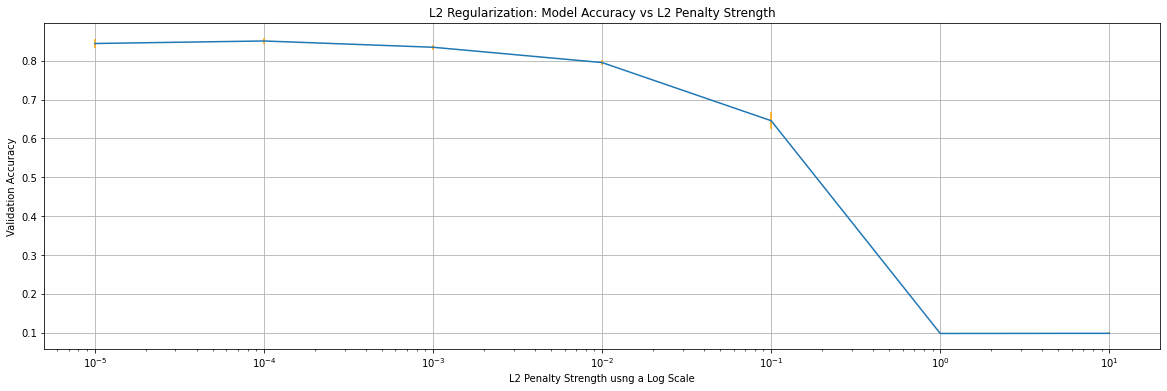

In [11]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# move l2 penalty values outside of dictionary and into a list
param_values = [dic["reg_penality"] for dic in params]

# plot accuracy vs l2_reg_penalty
plt.figure(figsize=(20,6))
plt.grid()

# this plot is using the std of the CV splits to plot error bars however those values are so small that they aren't visable
plt.errorbar(param_values, means, yerr=stds, ecolor="orange")
plt.xscale("log") # use a log scale for ease of reading, recall that l2_reg_penalty were in powers of 10 
plt.title("L2 Regularization: Model Accuracy vs L2 Penalty Strength")
plt.ylabel("Validation Accuracy", )
plt.xlabel("L2 Penalty Strength usng a Log Scale");

### Observations

Write down some observations. What do you notice from the plot?

The L2 regularization penalty value for the best performing model is 0.0001 
The L2 regularization penalty value for the worst performing models are 1 and 10. 



## Compare Weights between Best and Worse Model 

Next, we are going to compare the hidden layer weights between the best and worse performing model while taking note of the respective l2 penalty strengths.

In [12]:
# get the best l2 penalty term 
best_lr_penalty = grid_result.best_params_["reg_penality"]

# get the best trained model 
best_model = grid_result.best_estimator_.model

# get the weights from the best trained model 
best_weights = best_model.get_weights()

In [13]:
# train a model using the l2_reg_penalty value at scored the lowest 
worse_l2_reg_penalty = 10.0

worse_model = build_complex_model(Lp_reg=l2, reg_penality=worse_l2_reg_penalty)

# fit model 
worse_model.fit(X_train, y_train, epochs=3)

# get weights from worse performing model 
worse_weights = worse_model.get_weights()

Epoch 1/3
1875/1875 [==============================] - 5s 3ms/step - loss: 647.8049 - accuracy: 0.1130
Epoch 2/3
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3029 - accuracy: 0.0998
Epoch 3/3
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3031 - accuracy: 0.0997


-----
## Understanding how Weights and Biases are stored

Let's take a minute to understand that`.get_weights()` returns a list with 8 elements (if you're using `build_complex_model`).

In [14]:
len(best_weights)

8

There are **weights matrices and bias vectors between each layer** and we have 5 layers. 

- Input
- Hidden 1
- Hidden 2
- Hidden 3
- Output 

So that means we should have 4 weight matrices, but we see 8. **There are also 4 weight vectors for the biases between each layer.** So that accounts for the 8. 


#### Index for Weight Matrices 
If you index for a weight matrix, you can see its shape and that they are indeed matrices. 

Notice how you can see the dims of the layers that the matrices are sandwiched between?

Input layer has 784 dims and hidden layer 1 has 500 nodes/dims. Given this understanding, the numbers you see in the shapes should make sense. 

In [15]:
# bewteen input and 1st hidden layer
best_weights[0].shape

(784, 500)

In [16]:
# bewteen 1st and 2nd hidden layer
best_weights[2].shape

(500, 250)

In [17]:
# bewteen 2st and 3nd hidden layer
best_weights[4].shape

(250, 64)

In [18]:
# bewteen 3rd hidden layer and output layer
best_weights[6].shape

(64, 10)

#### Index for the bias vectors

The shapes of the bias vectors should exactly match up the dims/nodes of each layer (excluding the input layer). 

In [19]:
# for hidden layer 1 
best_weights[1].shape

(500,)

In [20]:
# for hidden layer 2 
best_weights[3].shape

(250,)

In [21]:
# for hidden layer 3
best_weights[5].shape

(64,)

In [22]:
# for output layer
best_weights[7].shape

(10,)

-----

### Back to our Analysis of L2 space regularization (also known as Ridge)

Let's do a comparison of the first weight matrix (between the input and 1st hidden layer) for the best and worse performing model as well as with the initial weight values that are randomly sampled from the GlorotUniform distribution.

[**Check out the Keras docs for the Dense layer**](https://keras.io/api/layers/core_layers/dense/), you'll see that GlorotUniform is the default weight initializer. 

In [23]:
# index for the 1st hidden layer weights in best_weights and save to best_hidden_weights

# index for the 1st hidden layer weights in worse_weights and save to worse_hidden_weights

# Keras models randomly samples from the GlorotUniform distribution for the initial values of model weights 
# instantiate GlorotUniform and sample 128 weights and save to initial_weight_values
# hint: use shape=(1, 128)

# YOUR CODE HERE

best_hidden_weights = best_weights[0].T[0]

worse_hidden_weights = worse_weights[0].T[0]


# let's take 784 random samples form the GlorotUniform
# because they are random samples their exact values might have been a little different for model and norm_model - but we will assume that they were not statistically different 
# 784 because that's how many weights are in the hidden layer for both of our models
initializer = tf.keras.initializers.GlorotUniform(seed=1234)
initial_weight_values = initializer(shape=(1, 784))[0].numpy()

best_hidden_weights, worse_hidden_weights.shape, initial_weight_values

(array([ 9.42717833e-08,  3.82874750e-05, -4.07750340e-05,  1.41785195e-05,
         1.07704531e-04, -8.54432466e-04,  6.09021750e-04,  4.81416378e-03,
        -5.53112710e-03,  1.97763629e-02,  6.20531924e-02,  1.01477519e-01,
         2.33976971e-02,  5.42945368e-03, -1.19328620e-02, -2.37196754e-03,
         7.20395595e-02,  2.14748736e-02,  3.78512479e-02,  1.37353211e-03,
        -1.76502857e-03,  6.31164387e-03, -7.22061144e-04, -2.22223951e-03,
        -8.13481456e-04, -5.53771606e-05, -5.93422692e-06,  2.33109367e-05,
        -2.79353953e-05,  5.88964622e-06, -1.45900249e-05, -2.71830300e-04,
        -4.95844870e-04, -1.45513343e-03, -3.61954095e-03, -2.61223577e-02,
        -2.43243147e-02, -1.56648643e-02, -1.41710453e-02,  5.53794987e-02,
        -3.55953537e-02,  3.79647166e-02, -2.46897247e-02,  3.38871181e-02,
         2.13977303e-02,  5.03970962e-03, -4.67724800e-02, -5.52700181e-03,
        -4.81356159e-02, -6.50265999e-03, -3.64563719e-04, -2.84381257e-03,
        -2.1

In [24]:
# move all weights to a dataframe for ease of analysis 
cols = ["best_hidden_weights", "worse_hidden_weights", "initial_weight_values"]
data = [best_hidden_weights, worse_hidden_weights, initial_weight_values]
df = pd.DataFrame(data=data).T
df.columns = cols


In [25]:
# check out the statistics for each weight column 
display(df.describe())
df.head()

,best_hidden_weights,worse_hidden_weights,initial_weight_values
count,784.000000,7.840000e+02,784.000000
mean,-0.005707,1.108495e-07,0.000399
std,0.025973,8.647196e-06,0.049670
min,-0.099861,-4.831167e-05,-0.087288
25%,-0.018734,-6.484926e-17,-0.040161
50%,-0.002714,1.496528e-16,-0.000564
75%,0.001566,5.075949e-16,0.043224
max,0.101478,2.268762e-04,0.087155


,best_hidden_weights,worse_hidden_weights,initial_weight_values
0,9.427178e-08,2.740948e-18,0.042257
1,3.828748e-05,2.692000e-18,0.082489
2,-4.077503e-05,3.831023e-07,-0.051885
3,1.417852e-05,6.503449e-18,0.050004
4,1.077045e-04,6.616435e-18,-0.014014


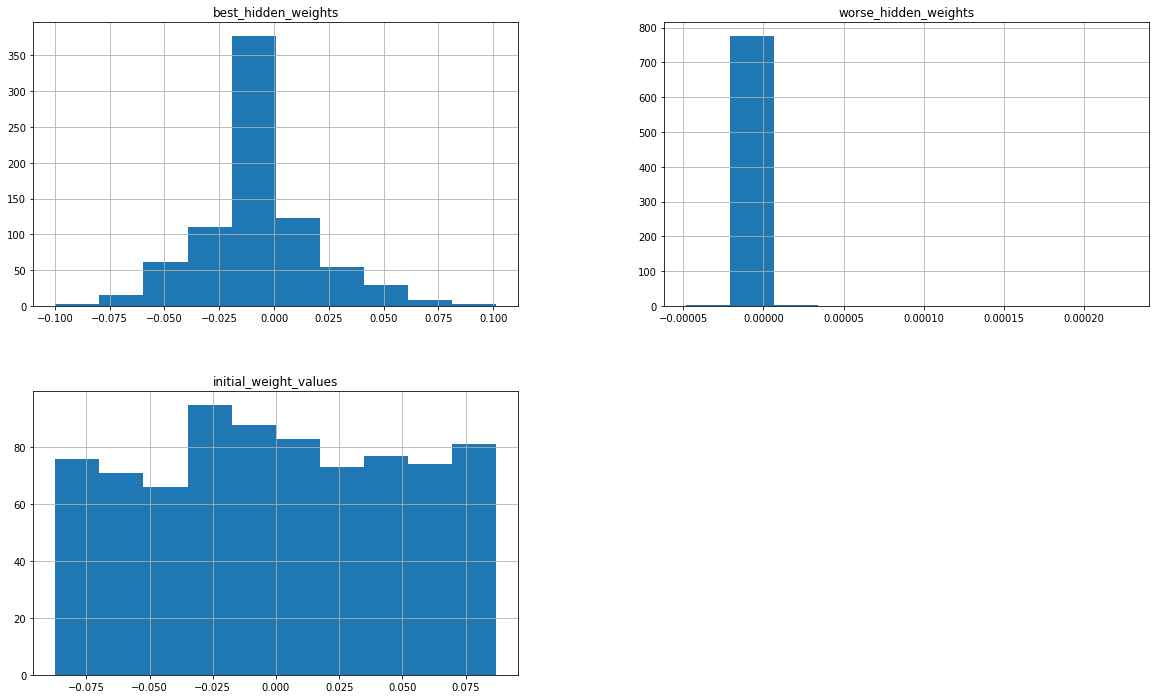

In [26]:
# plot the distributions for each weight column 
df.hist(figsize=(20,12));

## Observations 

Take a look at the statistical table and the plots. Then answer the following questions. 

**How do the hidden layer weights from the best performing model compare to the initial weight values?**

The hidden layer weights from the best performing model have more of a normal distribution as compared to the relatively uniform distribution of the initial weightThe hidden layer weights from the best performing model have more of a normal distribution as compared to the relatively uniform distribution of the initial weigh values. values.

**What was the effect of using a small l2 penalty value?**

A small L2 penalty value tends to spread the weights into a normal distribution centred around zero.

**What was the effect of using a large l2 penalty value?**

A large L2 penalty value tends to squeeze the weights into a narrow band around zero.

**Given what you know about L2 regularization, are you surprised by these results?**

Since L2 regularization involves modifying the cost gradient by subtracting $\lambda*2*w$(where $\lambda$ is the L2 penalty value), the larger L2 penalty values will tend to push the weights closer to zero.
So, the results are not surprising.

----

# Experiment 2: Identify the relationship between model performance and Max Norm Weight Constraint

![](https://qph.fs.quoracdn.net/main-qimg-9d0dbf8074761b541ba80543ddfc9f73.webp)

Recall from lecture that the **Norm** of a vector is just another word for the **length** of a vector.

MaxNorm weight constraint puts a limit on the length of a weight vector.

$$ \text{Max_value_of_norm} >= {\displaystyle \left\|x\right\|_{p}=\left(|x_{1}|^{p}+|x_{2}|^{p}+\dotsb +|x_{n}|^{p}\right)^{1/p}.}$$  

The effect that Lp regularization and Max Norm Weight Constraint have on the weights should be the same, but they go about it in different ways. 

Lp regularization (l1/Lasso and l2/Ridge) shrink the value of the weights. Where as Max Norm Weight Constraint puts a limit on how big the weight vector can be which, in effect, keeps the individual weight values small enough to keep the norm below that limit. 

In this experiment, we are going to run another gridseach but instead of using Lp space regularization as we did in the previous experiment, we are going to use MaxNorm and see what kind of effect that this type of regularization has on model performance and the learned weights. 

Since we already built our model, we just need to update the `hyper_parameters` dictionary. 

In [27]:
# remember to wrap KerasClassifier around build_model for sklearn's GridsearchCV compatibility 
#model = KerasClassifier(build_fn = build_complex_model)

# build out our hyperparameter dictionary 
hyper_parameters = {
    
    "maxnorm_wc": np.linspace(0.5, 10.0, num=20).tolist(), 
    # default is 1, in order to change it we must provide value here because we can't provide a parameter value for model.fit() directly when using gridsearch
    # protip: consider changing epochs to 1 if the gridsearche run-time are too long for you    
    "epochs": [1] 
}

hyper_parameters

{'maxnorm_wc': [0.5,
  1.0,
  1.5,
  2.0,
  2.5,
  3.0,
  3.5,
  4.0,
  4.5,
  5.0,
  5.5,
  6.0,
  6.5,
  7.0,
  7.5,
  8.0,
  8.5,
  9.0,
  9.5,
  10.0],
 'epochs': [1]}

In [28]:
start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/envs/U4-S2-NN/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


maxnorm_wc = 3.0
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5912 - accuracy: 0.7875


In [29]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))
grid.best_params_

Gridsearch runtime 2.91 mins


{'epochs': 1, 'maxnorm_wc': 3.0}

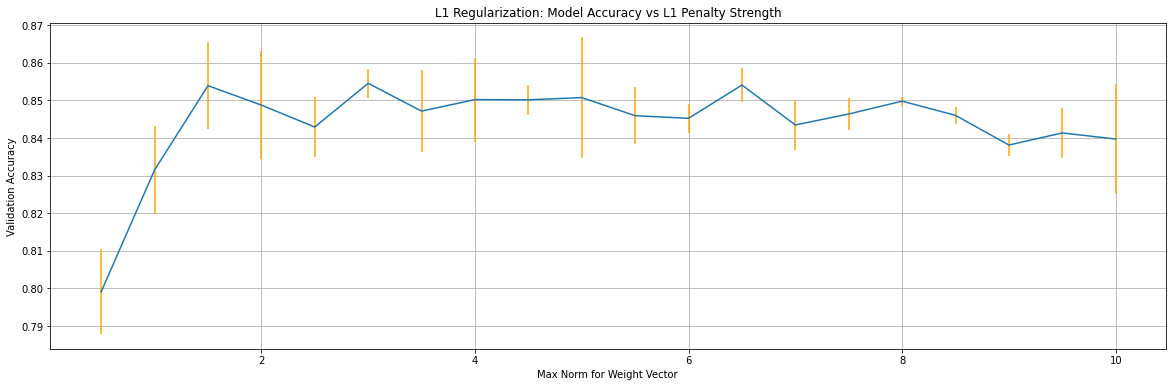

In [30]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

# move l2 penalty values outside of dictionary and into a list
param_values = [dic["maxnorm_wc"] for dic in params]

# plot accuracy vs l2_reg_penalty
plt.figure(figsize=(20,6))
plt.grid()
plt.errorbar(param_values, means, yerr=stds, ecolor="orange")
plt.title("L1 Regularization: Model Accuracy vs L1 Penalty Strength")
plt.ylabel("Validation Accuracy", )
plt.xlabel("Max Norm for Weight Vector ");

In [31]:
# get the best l2 penalty term from grid and save to best_max_norm_val

# get the best trained model from grid and save to best_model

# get the weights from the best trained model and save to best_weights

# YOUR CODE HERE

best_max_norm_val = grid.best_params_['maxnorm_wc']

best_model = grid.best_estimator_.model

best_weights = best_model.get_weights()

best_hidden_weights = best_weights[0].T[0]

In [32]:
best_max_norm_val

3.0

In [33]:
# we see that the norm of our weights are indeed below the maximum allowed value 
np.linalg.norm(best_hidden_weights)

1.3010439

In [34]:
# train a model using the max_norm_val value that scored the lowest 

# build a model using build_complex_model and worse_max_norm_val and save it to worse_model

# fit model 

# get weights from worse performing model 


# YOUR CODE HERE

worse_max_norm_val = 0.5

worse_model = build_complex_model(maxnorm_wc=worse_max_norm_val)

worse_model.fit(X_train, y_train, epochs=3)

worse_weights = worse_model.get_weights()

maxnorm_wc = 0.5
Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7296 - accuracy: 0.7295
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4902 - accuracy: 0.8199
Epoch 3/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4850 - accuracy: 0.8210


In [35]:
# YOUR CODE HERE
worse_hidden_weights= worse_weights[0].T[0]

In [36]:
# move all weights to a dataframe for ease of analysis 
cols = ["best_hidden_weights", "worse_hidden_weights", "initial_weight_values"]
data = [best_hidden_weights, worse_hidden_weights, initial_weight_values]
df_maxnorm= pd.DataFrame(data=data).T
df_maxnorm.columns = cols

In [37]:
df_maxnorm.describe()

,best_hidden_weights,worse_hidden_weights,initial_weight_values
count,784.000000,784.000000,784.000000
mean,-0.008066,-0.004701,0.000399
std,0.045790,0.017238,0.049670
min,-0.107514,-0.092275,-0.087288
25%,-0.046743,-0.011986,-0.040161
50%,-0.010100,-0.004317,-0.000564
75%,0.026907,0.004676,0.043224
max,0.118377,0.051690,0.087155


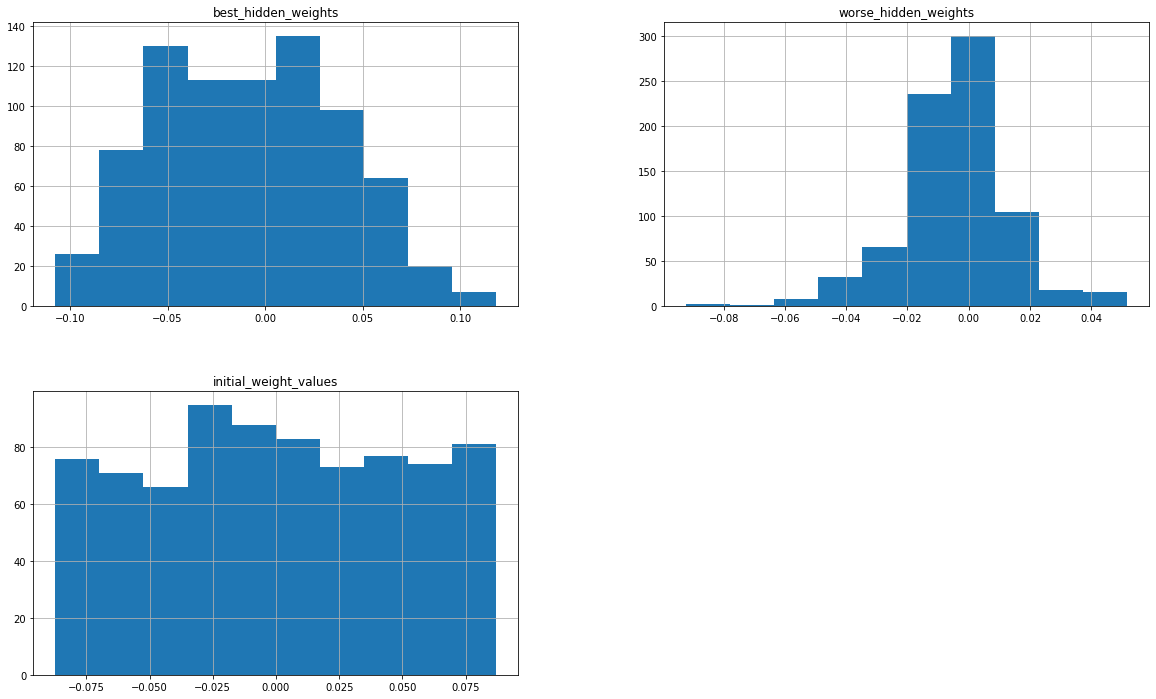

In [38]:
# plot the distributions for each weight column 
df_maxnorm.hist(figsize=(20,12));

## Observations 

Take a look at the statistical table and the plots. Then answer the following questions. 

**How do the hidden layer weights from the best performing model compare to the initial weight values?**

The hidden layer weights from the best performing model have more of a bimodal distribution as compared to the relatively uniform distribution of the initial weigh values.

**What was the effect of using the weight constraint value in MaxNorm in the best performing model?**

The larger weight constraint value for the best performing model pushed the weights into a bimodal distribution with modal values on either size of zero.

**What was the effect of using the weight constraint value in MaxNorm in the worse performing model?**

The smaller weight constraint value for the worst performing model pushed the weights into a narrow normal distribution centred at zero.

**Given what you know about MaxNorm regularization, are you surprised by these results?**

Since the MaxNorm regularization limits the norm(length) of the weight vector, the results are not suprising.

-----
# Experiment 3: Identify the relationship between model performance and Dropout


![](https://miro.medium.com/max/981/1*EinUlWw1n8vbcLyT0zx4gw.png)

In the 3rd and final experiment, we will use gridsearch to see how model performance is affect by varying the value of the the dropout probability. 

Recall from lecture that dropout tends to perform best when used with weight constraint. Since this is the case, we will gridsearch both dropout probability and the weight constraint for MaxNorm. 

If interested, feel free to read through the original publication on [**Drop Out**](https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf). 

**Key Take aways:** 

1. During training, dropout will probabilistically "turn off" some neurons in the layer that dropout is implemented in. 
2. During inference (ie. making predictions on the test set) all neurons are used (i.e. no dropout is applied).
3. Dropout works best when used with MaxNorm


In [39]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    # for the sake of runtime, let's vary maxnorm_wc between 0.5 and 5.0
    "maxnorm_wc": np.linspace(0.5, 5, num=10).tolist(),
    # take note that l1_reg_penalty values are in powers of 10 
    "dropout_prob": np.linspace(0.0, 0.6, num=7).tolist(), 
    "epochs": [1] # default is 1, in order to change it we must provide value here because we can provide a parameter value for model.fit() directly when using gridsearch
}

hyper_parameters

{'maxnorm_wc': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
 'dropout_prob': [0.0,
  0.09999999999999999,
  0.19999999999999998,
  0.3,
  0.39999999999999997,
  0.49999999999999994,
  0.6],
 'epochs': [1]}

In [40]:
start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 3 folds for each of 70 candidates, totalling 210 fits


/opt/anaconda3/envs/U4-S2-NN/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


maxnorm_wc = 4.5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5874 - accuracy: 0.7907


In [41]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

Gridsearch runtime 9.55 mins


In [42]:
grid_result.best_params_, grid_result.best_score_

({'dropout_prob': 0.0, 'epochs': 1, 'maxnorm_wc': 4.5}, 0.8551833232243856)

In [43]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

# move l2 penalty values outside of dictionary and into a list
param_values = [dic["dropout_prob"] for dic in params]

Since there are 2 indepdent variables this time around (dropout_prob and maxnorm_wc) which affect the validation accuracy, it's best to use a different plot. A heat map will work. 

In [44]:
dropout_prob_list = [  dic["dropout_prob"]  for dic in params]
maxnorm_wc_list = [  dic["maxnorm_wc"]  for dic in params]
data = [means, dropout_prob_list, maxnorm_wc_list ]

cols = ["val_acc", "dropout_prob", "maxnorm_wc"]
df_exp3 =pd.DataFrame(data=data).T
df_exp3.columns = cols
df_exp3.dropout_prob = df_exp3.dropout_prob.round(2)

# pivot dataframe in preperation for heat map
df_exp3 = df_exp3.pivot("maxnorm_wc", "dropout_prob", "val_acc")

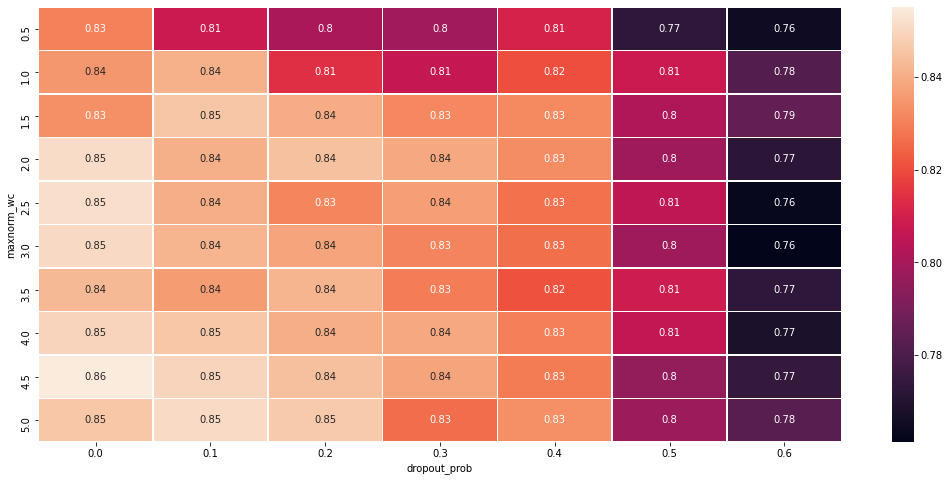

In [45]:
# Draw a heatmap with the val_acc values in each cell
f, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(df_exp3, annot=True,  linewidths=.5, ax=ax);

### Observations 

We can see the dropout probabilities in the horizontal axis and the maxnorm weight constraint values in the virtical axis. The values in the cells are the validation accuracy that corresponds to a pair of regularization values.

Take a look at the heat map and answer the following questions. Note that depending on which model you used (the simple or complex one) your answers might be different from that of others. 

**What range of dropout probability values tend to produce the highest validation accuracy?**

YOUR ANSWER HERE

**What range of maxnorm weight constraints tend to produce the highest validation accuracy?**

YOUR ANSWER HERE

**When taken together, what pair of dropout probability and maxnorm weight constraints tend to produce the highest validation accuracy?**

YOUR ANSWER HERE

**Do you think that using dropout was helpful in increasing model performance?**

YOUR ANSWER HERE

_____

### Experiment 4: Train, Save, and Load a Keras model

Let's get some practice with how to save and load trained Keras models 

For this experiment, review the section on Saving and Loading models from the guided project in order to help you to: 

- Build a model of your choosing
- Gridsearch the model with a method of your choosing
- Save the trained model to file
- Load the trained model from file
- Just as we did in the Guided Project, evalute the loaded model using a test set and make sure the results of the loaded model match that of the saved model 

In [46]:
model = grid_result.best_estimator_.model

model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 848us/step - loss: 0.4142 - accuracy: 0.8520


[0.41418251395225525, 0.8519999980926514]

In [47]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [48]:
smodel = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
smodel.evaluate(X_test, y_test)

313/313 [==============================] - 0s 780us/step - loss: 0.4142 - accuracy: 0.8520


[0.41418251395225525, 0.8519999980926514]